CE 5506 — Introducción al Reconocimiento de Patrones  
Examen 2 — Práctico  
Shakime Richards Sparks  — 2018170667

# II. Parte Práctica
Para esta sección, trabajaremos con el conjunto de datos de diabetes proporcionado por la biblioteca sklearn. Podemos obtener este conjunto de datos utilizando el método "load diabetes". Para establecer la etiqueta, elegiremos el valor límite de 150. Esto significa que si el valor objetivo es mayor a 150, consideraremos que la persona tiene diabetes; de lo contrario, consideraremos que no padece de diabetes.

## Creación de una red fullyconnected

In [1585]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings
import numpy as np
import pandas as pd
import time
import random

# Load set
diabetes = load_diabetes()
df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)

# Set the target
target = np.where(diabetes.target > 150, 1, 0)
df['diabetes'] = target

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,diabetes
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,1
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,1
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,0


2. Realice todo el proceso de feature engineering antes de entrenar la red. Obtenga el 80 % de los datos para entrenamiento. (5 puntos)

<Axes: >

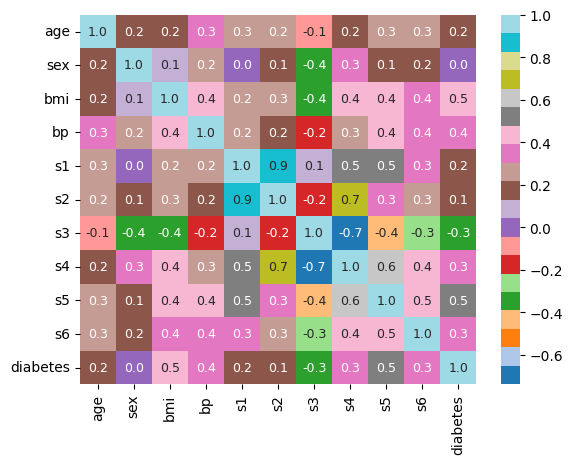

In [1586]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='tab20', annot_kws={"fontsize": 9},  fmt='.1f')

In [1587]:
'''
Dado que los valores en el conjunto de datos de diabetes ya están procesados, 
la correlación que se pueda calcular a partir de ellos no reflejará directamente 
la relación original entre las variables. Por lo tanto, en este caso, no tiene 
sentido eliminar los valores con una correlación baja, ya que esta 
correlación no está relacionada con la magnitud o la importancia de las variables 
en el contexto original.
'''
# Aun así, el sexo es una característica que no aporta nada 
# según la gráfica por lo que se puede eliminar.
df = df.drop('sex', axis=1)

X = df.drop('diabetes', axis=1).values
y = target

features = X.shape[1]
output_layer = 2
print(f"Dimensions X: {X.shape}")
print(f"Dimensions y: {y.shape}")

Dimensions X: (442, 9)
Dimensions y: (442,)


In [1588]:
'''
Los valores ya se encuentran estandarizados y normalizados, aun así se 
realiza nuevamente por si acaso.
'''

# Normalization
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Standardization
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_normalized)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42, stratify=y)

1. Realice una red completamente conectada (fully connected) con 4 capas ocultas, cuyos tamaños son: 10, 32, 16, 4. Estas capas deben estar conectadas a la entrada y la salida. Para este punto, no se permite el uso de bibliotecas como sklearn o keras (o cualquier otra que implemente el modelo). Cabe destacar que la red debe considerar el parámetro de sesgo (bias), así como el parámetro de la función de activación ReLU (prelu). Se requiere que la función de activación entre las capas ocultas sea prelu. (10 puntos)

In [1589]:
class PerceptronMultilayerMultiSize:
    
    def __init__(self, layers, layer_functions='prelu'):
        self.layers = layers
        self.bias = []
        self.weights = []
        self.layer_functions = layer_functions
        self.activation_derivatives = {
            'prelu': self.prelu_activation_derivative
        }
        self.activations = {
            'prelu': self.prelu_activation
        }
        for i in range(len(layers) - 1):
            # Initialize weights and biases for each layer
            weights = np.random.randn(layers[i], layers[i+1])
            self.weights.append(weights)
            bias = np.random.randn(layers[i+1])
            self.bias.append(bias)

    def prelu_activation(self, x):
        # PReLU activation function
        alpha = self.alpha
        return np.maximum(0, x) + alpha * np.minimum(0, x)

    def prelu_activation_derivative(self, x):
        # Derivative of PReLU activation function
        alpha = self.alpha
        return np.where(x > 0, 1, alpha)

    def feedforward(self, X):
        # Calculate the output of each layer
        layer_activation = [X]
        for i in range(len(self.layers) - 1):
            x = np.dot(layer_activation[i], self.weights[i]) + self.bias[i]
            y = self.activations[self.layer_functions[i]](x)
            layer_activation.append(y)

        return layer_activation

    def backpropagation(self, X, y, layer_activation):
        # Calculate the error of the output layer
        error = layer_activation[-1] - y
        delta = error * self.activation_derivatives[self.layer_functions[-1]](layer_activation[-1])
        
        # Backpropagate the error through the neural network
        for i in reversed(range(len(self.layers) - 1)):
            current_activation = layer_activation[i]
            weight_delta = np.outer(current_activation, delta)
            bias_delta = delta
            self.weights[i] -= self.alpha * weight_delta
            self.bias[i] -= self.alpha * bias_delta
            if i != 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivatives[self.layer_functions[i]](current_activation)

    def fit(self, X, y, alpha, epochs, show_loss=True):
        self.alpha = alpha
        losses = []  # Store the losses for each epoch

        for epoch in range(epochs):
            epoch_loss = 0  # Accumulate the loss for each epoch

            for i in range(len(X)):
                # Feedforward
                layer_activation = self.feedforward(X[i])

                # Backpropagation
                self.backpropagation(X[i], y[i], layer_activation)
                
                # Calculate the loss
                output = layer_activation[-1]
                loss = np.mean(np.square(output - y[i]))
                epoch_loss += loss

            # Calculate the average loss for the epoch
            epoch_loss /= len(X)
            losses.append(epoch_loss)

            if show_loss:
                print(f"● Epoch: {str(epoch + 1).ljust(5)}—   Loss: {epoch_loss}")

        return losses

    def predict(self, X):
        # Get the output of the last layer
        layer_activation = self.feedforward(X)
        return layer_activation[-1]
    
    def evaluate_metrics(self, X, y):
        y_pred = self.predict(X)
        y_pred_classes = np.argmax(y_pred, axis=1)
        accuracy = accuracy_score(y, y_pred_classes)
        f1 = f1_score(y, y_pred_classes, average='weighted')
        return accuracy, f1

# Create the multilayer perceptron
perceptronMultiSize = PerceptronMultilayerMultiSize(
    layers=[features, 10, 32, 16, 4, output_layer],
    layer_functions=['prelu', 'prelu', 'prelu', 'prelu', 'prelu']
)

3. Obtenga los mejores parámetros (al menos la tasa de aprendizaje - learning rate - y el número de épocas - epochs) para el modelo creado utilizando una herramienta como GridSearch u Optuna. (2 puntos)

In [1590]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the hyperparameters to tune
param_grid = {
    'learning_rate_init': [0.00001, 0.00003, 0.00006, 0.00009, 0.0002, 0.0006],
    'max_iter': [10, 15, 20, 25, 30]
}

# Create an instance of the MLPClassifier model with custom PReLU activation
model = MLPClassifier(hidden_layer_sizes=(features, 10, 32, 16, 4, 2), activation='relu')

# Create and fit GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Assign the best estimator to the model variable
model = grid_search.best_estimator_

# Print the best parameters and the corresponding accuracy score
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


Best parameters: {'learning_rate_init': 0.0006, 'max_iter': 15}
Best score: 0.5833400402414487


4. Realice el entrenamiento del modelo de manera que se imprima la pérdida (loss) en cada época. (5 puntos)

In [1591]:
# Set best params
learning_rate = best_params['learning_rate_init']
epochs = best_params['max_iter']
y_train_eye = np.eye(output_layer)[y_train]

# Train
start_time = time.time()
perceptronMultiSize.fit(X=X_train, y=y_train_eye, alpha=learning_rate, epochs=epochs)
train_time = time.time() - start_time

● Epoch: 1    —   Loss: 1.149340465151647
● Epoch: 2    —   Loss: 0.5266228912032677
● Epoch: 3    —   Loss: 0.524543961528099
● Epoch: 4    —   Loss: 0.5243104848117468
● Epoch: 5    —   Loss: 0.5223968995056443
● Epoch: 6    —   Loss: 0.5217445893971491
● Epoch: 7    —   Loss: 0.5210363660078924
● Epoch: 8    —   Loss: 0.5204131133324038
● Epoch: 9    —   Loss: 0.5198160442213275
● Epoch: 10   —   Loss: 0.5192345244874245
● Epoch: 11   —   Loss: 0.5186646500232818
● Epoch: 12   —   Loss: 0.5181126355217486
● Epoch: 13   —   Loss: 0.5175739000553584
● Epoch: 14   —   Loss: 0.5170569060151705
● Epoch: 15   —   Loss: 0.516555922445051


5. Obtenga el accuracy y F1 final, así como el tiempo de ejecución. (3 puntos)

In [1592]:
# Metrics
accuracy_1, f1_1 = perceptronMultiSize.evaluate_metrics(X_test, y_test)
print(f"● Accuracy: {accuracy_1:.2f}")
print(f"● F1 Scores: {f1_1:.2f}")
print(f"● Execution time: {train_time:.4f}")

● Accuracy: 0.53
● F1 Scores: 0.43
● Execution time: 0.9336


## Optimizar la red creada
1. Enumere qué cambios se podrían realizar al modelo anterior para mejorar los resultados (1 punto):

1.1 - *Cambiar la función de salida, por la función softmax para un entrenamiento más estable. Así, al restar el máximo valor de las activaciones en Softmax, se evitan posibles problemas de desbordamiento numérico al calcular las exponenciales. Como sucede en ciertas ocasiones al ejecutar el modelo anterior.*

2.  Implemente los cambios indicados y demuestre la mejoría con las métricas. (5 puntos)

In [1593]:
class PerceptronMultilayerMultiSizeImproved:
    
    def __init__(self, layers, layer_functions='prelu'):
        self.layers = layers
        self.bias = []
        self.weights = []
        self.layer_functions = layer_functions
        self.activation_derivatives = {
            'prelu': self.prelu_activation_derivative,
            'softmax': self.softmax_activation_derivative
        }
        self.activations = {
            'prelu': self.prelu_activation,
            'softmax': self.softmax_activation
        }
        for i in range(len(layers) - 1):
            # Initialize weights and biases for each layer
            weights = np.random.randn(layers[i], layers[i+1])
            self.weights.append(weights)
            bias = np.random.randn(layers[i+1])
            self.bias.append(bias)
        
    def prelu_activation(self, x):
        # PReLU activation function
        alpha = self.alpha
        return np.maximum(0, x) + alpha * np.minimum(0, x)

    def prelu_activation_derivative(self, x):
        # Derivative of PReLU activation function
        alpha = self.alpha
        return np.where(x > 0, 1, alpha)

    def softmax_activation(self, x):
        # Softmax activation function
        e_x = np.exp(x - np.max(x))  # Subtracting the maximum value for numerical stability
        return e_x / np.sum(e_x, axis=0)

    def softmax_activation_derivative(self, x):
        # Derivative of Softmax activation function
        output = self.softmax_activation(x)
        return output * (1 - output)

    def feedforward(self, X):
        # Calculate the output of each layer
        layer_activation = [X]
        for i in range(len(self.layers) - 1):
            x = np.dot(layer_activation[i], self.weights[i]) + self.bias[i]
            y = self.activations[self.layer_functions[i]](x)
            layer_activation.append(y)

        return layer_activation

    def backpropagation(self, X, y, layer_activation):
        # Calculate the error of the output layer
        error = layer_activation[-1] - y
        delta = error * self.activation_derivatives[self.layer_functions[-1]](layer_activation[-1])
        
        # Backpropagate the error through the neural network
        for i in reversed(range(len(self.layers) - 1)):
            current_activation = layer_activation[i]
            weight_delta = np.outer(current_activation, delta)
            bias_delta = delta
            self.weights[i] -= self.alpha * weight_delta
            self.bias[i] -= self.alpha * bias_delta
            if i != 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_derivatives[self.layer_functions[i]](current_activation)

    def fit(self, X, y, alpha, epochs, show_loss=True):
        self.alpha = alpha
        losses = []  # Store the losses for each epoch

        for epoch in range(epochs):
            epoch_loss = 0  # Accumulate the loss for each epoch

            for i in range(len(X)):
                # Feedforward
                layer_activation = self.feedforward(X[i])

                # Backpropagation
                self.backpropagation(X[i], y[i], layer_activation)
                
                # Calculate the loss
                output = layer_activation[-1]
                loss = np.mean(np.square(output - y[i]))
                epoch_loss += loss

            # Calculate the average loss for the epoch
            epoch_loss /= len(X)
            losses.append(epoch_loss)

            if show_loss:
                print(f"● Epoch: {str(epoch + 1).ljust(5)}—   Loss: {epoch_loss}")

        return losses

    def predict(self, X):
        # Get the output of the last layer
        layer_activation = self.feedforward(X)
        return layer_activation[-1]
    
    def evaluate_metrics(self, X, y):
        y_pred = self.predict(X)
        y_pred_classes = np.argmax(y_pred, axis=1)
        accuracy = accuracy_score(y, y_pred_classes)
        f1 = f1_score(y, y_pred_classes, average='weighted')
        return accuracy, f1

# Create the multilayer perceptron
perceptronMultiSize = PerceptronMultilayerMultiSizeImproved(
    layers=[features, 10, 32, 16, 4, output_layer],
    layer_functions=['prelu', 'prelu', 'prelu', 'prelu', 'softmax']
)

In [1594]:
# Train
start_time = time.time()
perceptronMultiSize.fit(X=X_train, y=y_train_eye, alpha=learning_rate, epochs=epochs)
train_time = time.time() - start_time

# Metrics
accuracy_2, f1_2 = perceptronMultiSize.evaluate_metrics(X_test, y_test)
print(f"\n● Accuracy: {accuracy_2:.2f}")
print(f"● F1 Scores: {f1_2:.2f}")
print(f"● Execution time: {train_time:.4f}")

● Epoch: 1    —   Loss: 0.4221985957030529
● Epoch: 2    —   Loss: 0.4072384569681772
● Epoch: 3    —   Loss: 0.3990572582694157
● Epoch: 4    —   Loss: 0.3882940116660032
● Epoch: 5    —   Loss: 0.382131525758139
● Epoch: 6    —   Loss: 0.38013056871305306
● Epoch: 7    —   Loss: 0.37354614470258474
● Epoch: 8    —   Loss: 0.37099709030958056
● Epoch: 9    —   Loss: 0.37946123671847587
● Epoch: 10   —   Loss: 0.37570788908756053
● Epoch: 11   —   Loss: 0.3749826204366562
● Epoch: 12   —   Loss: 0.3675408069654368
● Epoch: 13   —   Loss: 0.3613269202335889
● Epoch: 14   —   Loss: 0.368023162834986
● Epoch: 15   —   Loss: 0.36027338467577386

● Accuracy: 0.73
● F1 Scores: 0.73
● Execution time: 0.9940


## Resultados

In [1595]:
def pformat(value):
      r = format(100 * value, ".2f") + "%"
      return r
      
# Crear el DataFrame con los resultados antes y después de los cambios
df_results = pd.DataFrame(
      data=[["Accuracy", "{:.2f}".format(accuracy_1), "{:.2f}".format(accuracy_2), pformat(accuracy_2 - accuracy_1)],
            ["F1 Score", "{:.2f}".format(f1_1), "{:.2f}".format(f1_2), pformat(f1_2 - f1_1)]],
      columns=["Metric", "Original", "Improved", "Improvement"]
)
df_results

,Metric,Original,Improved,Improvement
0,Accuracy,0.53,0.73,20.22%
1,F1 Score,0.43,0.73,30.17%
